In [30]:
import time
import os
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [ ]:
root_path = '/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/'

image_file_list = glob.glob(root_path + '*.jpg')

for image_file in image_file_list:
    index = random.randint(0, len(image_file_list))
    print(image_file_list[index])

    image_file_name = image_file_list[index].split(".")[0]
    image_file_name = image_file_name.split("/")[-1]
    print(image_file_name)

    img = cv2.imread(root_path + image_file_name + '.jpg')
    mask = cv2.imread(root_path + image_file_name + '_seg.png')

    print(mask.shape)

    height = mask.shape[0]
    width = mask.shape[1]

    for i in range(height):
        for j in range(width):
            color_value = mask[i,j,:]

            #print("color_value[0]: " + str(color_value[0]))
            if color_value[1] == 208 or color_value[1] == 130:
                mask[i,j,:] = 0 
            elif color_value[1] == 162:
                mask[i,j,:] = 125
            else:
                mask[i,j,:] = 255
                
    cv2.imwrite(root_path + image_file_name + '_seg_simple.png', mask)


#plt.subplot(121)
#plt.imshow(img)
            
#plt.subplot(122)
#plt.imshow(mask)

/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00014024.jpg
ADE_train_00014024
(1536, 2048, 3)
/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00007061.jpg
ADE_train_00007061
(480, 720, 3)
/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00006957.jpg
ADE_train_00006957
(683, 1024, 3)
/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00007179.jpg
ADE_train_00007179
(945, 1056, 3)
/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00005634.jpg
ADE_train_00005634
(1200, 1600, 3)
/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00014065.jpg
ADE_train_00014065
(1224, 1632, 3)
/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/ADE_train_00007252.jpg
ADE_train_00007252
(1067, 800, 3)


In [2]:
train_path = '/media/kimbring2/Steam/sim2real/archive/ade20k_data/train/'
val_path = '/media/kimbring2/Steam/sim2real/archive/ade20k_data/val/'

def get_images_masks(root_path):
    image_file_list = glob.glob(root_path + '*.jpg')
    
    img_g, img_m = [], []
    for image_file in image_file_list:
        #print("image_file: " + str(image_file))
        
        image_file_name = image_file.split(".")[0]
        image_file_name = image_file_name.split("/")[-1]

        img = cv2.imread(root_path + image_file_name + '.jpg')
        mask = cv2.imread(root_path + image_file_name + '_seg.png')
        
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        #print("img.shape: " + str(img.shape))
        
        mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        #print("mask.shape: " + str(mask.shape))
        mask = np.reshape(mask,(256*256*3))
        
        img_g.append(img)
        img_m.append(mask)
        del img, mask
    del image_file_list
    return img_g,img_m
        
train_imgs, train_masks = get_images_masks(train_path)
valid_imgs, valid_masks = get_images_masks(val_path)

train_len = len(train_imgs)
valid_len = len(valid_imgs)
print(f'Train Images:{train_len}\nValid Images:{valid_len}')

Train Images:589
Valid Images:28


(256, 256, 3)
(256, 256, 3)


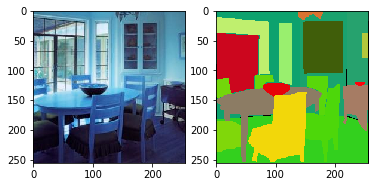

In [3]:
print(train_imgs[0].shape)

mask = np.reshape(train_masks[0],(256,256,3))
print(mask.shape)

plt.subplot(121)
plt.imshow(train_imgs[0])

plt.subplot(122)
plt.imshow(mask)

In [6]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

In [7]:
input_layer = tf.keras.Input(shape=np.squeeze(train_imgs[0]).shape,name='input')
output_layer = last_conv_module(input_layer)
model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block_1_a (Conv2D)              (None, 256, 256, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
block_1_batch_norm_a (BatchNorm (None, 256, 256, 32) 128         block_1_a[0][0]                  
__________________________________________________________________________________________________
block_1_leakyrelu_a (LeakyReLU) (None, 256, 256, 32) 0           block_1_batch_norm_a[0][0]       
______________________________________________________________________________________________

In [9]:
#model.load_weights('/kaggle/input/best-modelh5/best_model.h5')

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mse')
model.fit(np.array(train_imgs,dtype='float16'),np.array(train_masks,dtype='float16'),
          validation_data=(np.array(valid_imgs,dtype='float16'),np.array(valid_masks,dtype='float16')),
          epochs=500,steps_per_epoch=100,verbose=1,batch_size=5)

Train on 589 samples, validate on 28 samples
Epoch 1/500
499/589 [========================>.....] - ETA: 3s - loss: 0.0459 - val_loss: 0.0477Epoch 85/500


500/589 [========================>.....] - ETA: 3s - loss: 0.0386 - val_loss: 0.0384Epoch 251/500


499/589 [========================>.....] - ETA: 4s - loss: 0.0335 - val_loss: 0.0330Epoch 417/500


499/589 [========================>.....] - ETA: 4s - loss: 0.0315 - val_loss: 0.0320

In [14]:
def plot_imgs(img,mask,pred):
    mask = np.reshape(mask,(256,256,3))
    pred = np.reshape(pred,(256,256,3))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask)
    ax2.axis('off')
    ax3.imshow(pred)
    ax3.axis('off')

-------------Input---------------Actual mask--------------Predicted mask-------


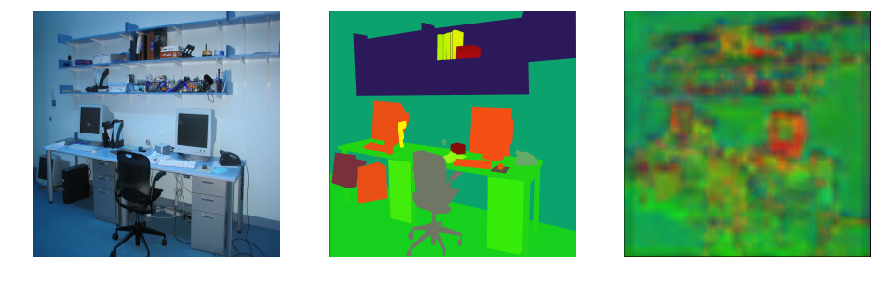

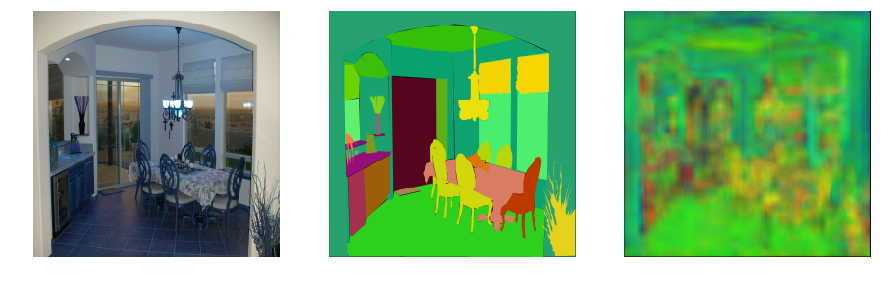

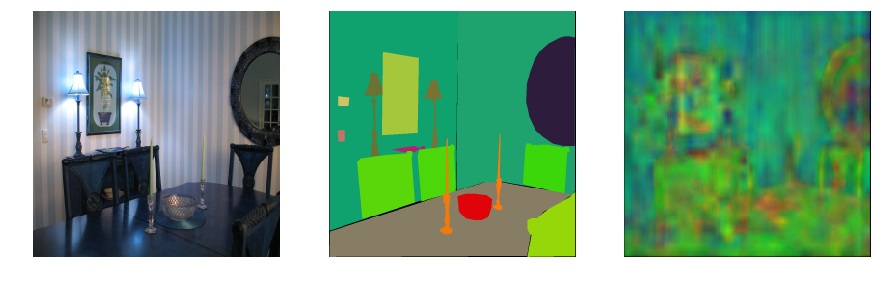

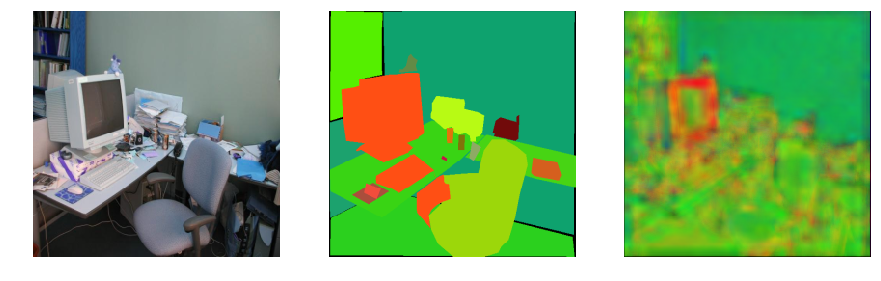

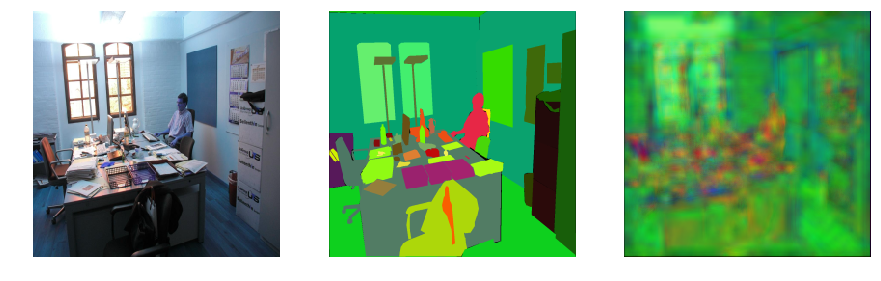

In [17]:
pred_masks = model.predict(np.array(valid_imgs,dtype='float16'))

print('-------------Input---------------Actual mask--------------Predicted mask-------')
for i in range(5):
    x = np.random.randint(0,20,size=1)[0]
    plot_imgs(valid_imgs[x],valid_masks[x],pred_masks[x])

pred_masks.shape: (256, 256, 3)


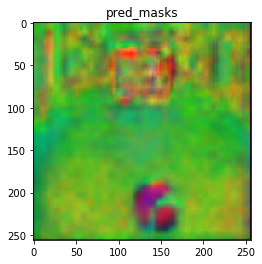

In [25]:
import cv2

#image_path = '/media/kimbring2/Steam/sim2real/images/tennis_ball_image/71HxOsmPUHL._AC_SL1201_.jpg'
#image_path = '/media/kimbring2/Steam/sim2real/images/deepsoccer_content.jpg'
image_path = '/home/kimbring2/Desktop/content_image/image_5.jpg'
test_image = cv2.imread(image_path)
test_image = cv2.normalize(test_image,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
#test_image = (test_image / 127.5) - 1

test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)

test_tensor = tf.image.resize(test_tensor, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_tensor = tf.reshape(test_tensor, [1,256,256,3], name=None)

pred_masks = model.predict(test_tensor)
pred_masks = np.reshape(pred_masks,(256,256,3))

print("pred_masks.shape: " + str(pred_masks.shape))

plt.title('pred_masks')
plt.imshow(pred_masks)